In [1]:
import pickle
import os
import rasterio
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import pandas as pd
from shapely import wkt
from tqdm import tqdm



In [2]:
def show(data):
    """
    Inspect the structure of the 'data' dictionary.
    For each year, it prints the available keys, types, and shapes if applicable.
    """
    print("🔎 Exploring data structure\n" + "-"*60)
    for year_key, year_data in data.items():
        print(f"{year_key}")
        
        if not isinstance(year_data, dict):
            print(f"  ⚠️ Expected dict, got {type(year_data)}\n")
            continue
        
        # Loop through subkeys (like imgs_array, iris_index, etc.)
        for key, value in year_data.items():
            info = f"  ├─ {key:<25} → "
            
            # Describe arrays
            if isinstance(value, (list, tuple)):
                info += f"list[{len(value)}]"
            elif isinstance(value, dict):
                info += f"dict[{len(value)}]"
            elif hasattr(value, "shape"):
                info += f"array shape={value.shape}, dtype={getattr(value, 'dtype', 'N/A')}"
            else:
                info += str(type(value))
            
            print(info)
        
        print("-"*60)

def save(data, save_path):
    with open(save_path, "wb") as f:
       pickle.dump(data, f)
    print(f"✅ Data saved successfully at: {save_path}")

def load(save_path):
    with open(save_path, "rb") as f:
       data = pickle.load(f)
    print("✅ Data loaded successfully!")

    return data
    
def read_band(file):
    """Lit une bande Landsat et nettoie les valeurs aberrantes."""
    with rasterio.open(file) as src:
        band = src.read(1).astype(float)
        # Supprime les valeurs saturées ou nulles
        band[(band <= 0) | (band >= 60000)] = 0
        return band
    
def get_array_img(path, date):
    B1 = ""
    B2 = ""
    B3 = ""
    B4 = ""
    B5 = ""
    B6 = ""
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            if f.lower().endswith("b1.tif"):
                B1 = os.path.join(dirpath, f)
            if f.lower().endswith("b2.tif"):
                B2 = os.path.join(dirpath, f)
            if f.lower().endswith("b3.tif"):
                B3 = os.path.join(dirpath, f)
            if f.lower().endswith("b4.tif"):
                B4 = os.path.join(dirpath, f)
            if f.lower().endswith("b5.tif"):
                B5 = os.path.join(dirpath, f)
            if f.lower().endswith("b6.tif"):
                B6 = os.path.join(dirpath, f)
    

    if date >= 2013:
        red = read_band(B6) 
        green = read_band(B5) 
        blue = read_band(B4)

        red = red / red.max()
        green = green / green.max()
        blue = blue / blue.max()
    
    else:
        red = read_band(B5)
        green = read_band(B4)
        blue = read_band(B3)

    
    rgb = np.dstack((red, green, blue))
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb_norm = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    rgb_8bit = (rgb_norm * 255).astype(np.uint8)

    return rgb_8bit

def return_tif_files(dir):
    for dirpath, _, filenames in os.walk(dir):
        for f in filenames:
            if f.lower().endswith(".tif"):
                path = os.path.join(dirpath, f)
                try:
                    with rasterio.open(path) as src:
                        if src.crs is not None and src.transform is not None:
                            return path
                
                except rasterio.errors.RasterioIOError:
                    continue

def get_grid_coordinates(path, format = "lat_lon"): #this file ends with .Tif

    with rasterio.open(path) as src:
        transform = src.transform
        crs = src.crs
        width, height = src.width, src.height

    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

    xs = np.array(xs).reshape(height, width)
    ys = np.array(ys).reshape(height, width)

    if format != "lat_lon":
        return xs, ys
    
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    lons, lats = transformer.transform(xs, ys)

    return lons, lats

def world_to_pixel(x, y, transform):
    """Convert geospatial coords (x,y) to pixel indices (row,col)."""
    col, row = ~transform * (x, y)
    return int(round(row)), int(round(col))

def pixel_to_world(col, row, transform):
    """Convert pixel indices (col,row) to geospatial coordinates (x,y)."""
    x, y = transform * (col, row)
    return x, y

def get_city_patch_params(city: str):
    """
    Returns i_start, j_start, i_length, j_length for a given city.
    """

    if city == "Lyon":
        i_start, j_start = 4400, 5000
        i_length, j_length = 1000, 800

    elif city == "Paris":
        i_start, j_start = 3000, 3000
        i_length, j_length = 1600, 1600

    elif city == "Toulouse":
        i_start, j_start = 1800, 2600
        i_length, j_length = 1000, 600

    elif city == "Bordeaux":
        i_start, j_start = 2600, 4100
        i_length, j_length = 800, 800

    elif city == "Lyon":
        i_start, j_start = 4800, 5000
        i_length, j_length = 500, 500

    elif city == "Clermont-Ferrand":
        i_start, j_start = 4776, 478
        i_length, j_length =  700, 400

    elif city == "Montpelier":
        i_start, j_start = 2185, 5183
        i_length, j_length = 520, 400

    elif city == "grenoble":
        i_start, j_start = 1527, 4424
        i_length, j_length = 420, 334

    elif city == "Nantes":
        i_start, j_start = 4519, 2992
        i_length, j_length = 645, 478

    elif city == "Rennes":
        i_start, j_start = 1308, 2858
        i_length, j_length = 466, 273

    else:
        raise ValueError(f"Unknown city: {city}")

    return i_start, j_start, i_length, j_length

def get_geospatial_coordinates(path, num_patch, i_start, j_start, i_length, j_length):

    
    path2021 = os.path.join(path, "2021")
    tif_2021 = return_tif_files(path2021)
    with rasterio.open(tif_2021) as src2021:
        transform2021 = src2021.transform
    
    i_s = np.random.randint(i_start, i_start+i_length, num_patch)
    j_s = np.random.randint(j_start, j_start+j_length, num_patch)

    x_s = [0]* num_patch
    y_s = [0]* num_patch

    for k in range(num_patch):
        i, j = i_s[k], j_s[k]
        x, y = pixel_to_world(j, i, transform2021)
        x_s[k], y_s[k] = x, y

    return x_s , y_s

def get_patches(x_s, y_s, path, patch_size):
    num_patches = len(x_s)
    data = {}

    for date in range(2013, 2022):
        if date != 2012:
            print(date)
            new_path = os.path.join(path, str(date))
            path_tif_file = return_tif_files(new_path)
            img = get_array_img(new_path, date)
            imgs_array = np.zeros((num_patches, patch_size, patch_size, 3), dtype=np.uint8)
            space_coordinates = np.zeros((num_patches, patch_size, patch_size, 2), dtype=np.float32)

            with rasterio.open(path_tif_file) as src:
                transform = src.transform
                crs = src.crs

            # prepare coordinate transformer (to lat/lon)
            transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

            for k in range(num_patches):
                x, y = x_s[k], y_s[k]
                i, j = world_to_pixel(x, y, transform)

                # image patch
                imgs_array[k, :, :, :] = img[i:i+patch_size, j:j+patch_size, :]

                # grid of pixel indices within the patch
                rows = np.arange(i, i + patch_size)
                cols = np.arange(j, j + patch_size)
                cols_grid, rows_grid = np.meshgrid(cols, rows)

                # convert to map coordinates
                xs, ys = rasterio.transform.xy(transform, rows_grid, cols_grid, offset="center")
                xs = np.array(xs).reshape((patch_size, patch_size))
                ys = np.array(ys).reshape((patch_size, patch_size))

                # convert map coords → lon/lat
                lons, lats = transformer.transform(xs, ys)

                # stack and save
                space_coordinates[k, :, :, :] = np.dstack((lats, lons)).astype(np.float32)

            data[str(date)] = {
                "imgs_array": imgs_array,
                "space_coordinates": space_coordinates
            }

    return data

def assign_iris_to_data(data, iris_csv_paths, batch_size=100_000):
    """
    Adds 'iris_index' arrays to the existing 'data' dictionary.
    Each iris_index has shape [num_patches, patch_size, patch_size],
    with each pixel containing its CODE_IRIS (string or np.nan).
    """

    for year, content in data.items():
        if not year.isdigit():
            continue
        if int(year) not in iris_csv_paths:
            print(f"⚠️ No IRIS CSV for {year}, skipping...")
            continue

        print(f"\n📅 Processing year {year}...")

        # Load IRIS polygons for that year
        iris_csv = iris_csv_paths[int(year)]
        iris_df = pd.read_csv(iris_csv)
        iris_df["geometry"] = iris_df["geometry"].apply(wkt.loads)
        iris_gdf = gpd.GeoDataFrame(iris_df, geometry="geometry", crs="EPSG:4326")

        # Get pixel coordinate array
        coords = content["space_coordinates"]  # shape [num_patches, H, W, 2]
        num_patches, H, W, _ = coords.shape
        total_points = num_patches * H * W

        print(f"   → Flattening {total_points:,} pixels...")

        # Flatten coordinates
        flat_coords = coords.reshape(-1, 2)
        lats = flat_coords[:, 0]
        lons = flat_coords[:, 1]

        # Prepare output
        codes = np.empty(total_points, dtype=object)

        # Process in batches
        for start in tqdm(range(0, total_points, batch_size), desc=f"Joining {year}", ncols=80):
            end = min(start + batch_size, total_points)
            batch_lats = lats[start:end]
            batch_lons = lons[start:end]

            # Create GeoDataFrame of points
            points_gdf = gpd.GeoDataFrame(
                geometry=gpd.points_from_xy(batch_lons, batch_lats),
                crs="EPSG:4326"
            )

            # Spatial join (vectorized)
            joined = gpd.sjoin(
                points_gdf,
                iris_gdf[["CODE_IRIS", "geometry"]],
                how="left",
                predicate="within"
            )

            codes[start:end] = joined["CODE_IRIS"].to_numpy()

        # Reshape back to [num_patches, H, W]
        iris_index = codes.reshape(num_patches, H, W)

        # Attach to data
        data[year]["iris_index"] = iris_index

        matched = np.count_nonzero(~pd.isna(codes))
        print(f"✅ Finished {year}: matched {matched:,}/{total_points:,} pixels")

    print("\n✅ Added 'iris_index' to all matching years.")
    return data

iris_csv_paths = {
    2011: r"C:\Users\adamh\Desktop\IRIS\2011\iris_latlon.csv",
    2012: r"C:\Users\adamh\Desktop\IRIS\2012\iris_latlon.csv",
    2013: r"C:\Users\adamh\Desktop\IRIS\2013\iris_latlon.csv",
    2014: r"C:\Users\adamh\Desktop\IRIS\2014\iris_latlon.csv",
    2015: r"C:\Users\adamh\Desktop\IRIS\2015\iris_latlon.csv",
    2016: r"C:\Users\adamh\Desktop\IRIS\2016\iris_latlon.csv",
    2017: r"C:\Users\adamh\Desktop\IRIS\2017\iris_latlon.csv",
    2018: r"C:\Users\adamh\Desktop\IRIS\2018\iris_latlon.csv",
    2019: r"C:\Users\adamh\Desktop\IRIS\2019\iris_latlon.csv",
    2020: r"C:\Users\adamh\Desktop\IRIS\2020\iris_latlon.csv",
    2021: r"C:\Users\adamh\Desktop\IRIS\2021\iris_latlon.csv",
}



In [3]:
city = "Montpelier"
base_dir = r"C:\Users\adamh\Desktop\Satelite_images"

save_path = os.path.join(base_dir, f"{city}_data.pkl")
city_path = os.path.join(base_dir, "Satellite_Images", city)

In [4]:
num_patch = 500
i_start, j_start, i_length, j_length = get_city_patch_params(city)
patch_size = 128

x_s, y_s = get_geospatial_coordinates(city_path, num_patch, i_start, j_start, i_length, j_length)
data = get_patches(x_s, y_s, city_path, patch_size)


2013
2014
2015
2016
2017
2018
2019
2020
2021


In [5]:
print(save_path)

C:\Users\adamh\Desktop\Satelite_images\Montpelier_data.pkl


In [6]:
data = assign_iris_to_data(data, iris_csv_paths)
save(data, save_path)


📅 Processing year 2013...
   → Flattening 8,192,000 pixels...


Joining 2013: 100%|█████████████████████████████| 82/82 [00:09<00:00,  8.35it/s]


✅ Finished 2013: matched 7,042,455/8,192,000 pixels

📅 Processing year 2014...
   → Flattening 8,192,000 pixels...


Joining 2014: 100%|█████████████████████████████| 82/82 [00:10<00:00,  8.08it/s]


✅ Finished 2014: matched 7,041,710/8,192,000 pixels

📅 Processing year 2015...
   → Flattening 8,192,000 pixels...


Joining 2015: 100%|█████████████████████████████| 82/82 [00:10<00:00,  8.12it/s]


✅ Finished 2015: matched 7,041,710/8,192,000 pixels

📅 Processing year 2016...
   → Flattening 8,192,000 pixels...


Joining 2016: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.97it/s]


✅ Finished 2016: matched 7,041,710/8,192,000 pixels

📅 Processing year 2017...
   → Flattening 8,192,000 pixels...


Joining 2017: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.88it/s]


✅ Finished 2017: matched 7,041,710/8,192,000 pixels

📅 Processing year 2018...
   → Flattening 8,192,000 pixels...


Joining 2018: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.99it/s]


✅ Finished 2018: matched 7,041,710/8,192,000 pixels

📅 Processing year 2019...
   → Flattening 8,192,000 pixels...


Joining 2019: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.91it/s]


✅ Finished 2019: matched 7,041,710/8,192,000 pixels

📅 Processing year 2020...
   → Flattening 8,192,000 pixels...


Joining 2020: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.71it/s]


✅ Finished 2020: matched 7,041,710/8,192,000 pixels

📅 Processing year 2021...
   → Flattening 8,192,000 pixels...


Joining 2021: 100%|█████████████████████████████| 82/82 [00:10<00:00,  7.85it/s]


✅ Finished 2021: matched 7,041,710/8,192,000 pixels

✅ Added 'iris_index' to all matching years.
✅ Data saved successfully at: C:\Users\adamh\Desktop\Satelite_images\Montpelier_data.pkl


                                     Remodeling the dataset

In [12]:
base_dir = r"C:\Users\adamh\Desktop\Satelite_images\Lyon_data.pkl"

data = load(base_dir)
show(data)

✅ Data loaded successfully!
🔎 Exploring data structure
------------------------------------------------------------
2013
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(500, 128, 128), dtype=object
------------------------------------------------------------
2014
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(500, 128, 128), dtype=object
------------------------------------------------------------
2015
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(500, 128, 128), dtype=object
------------------------------------------------------

In [5]:
def transform_to_patch_storing(data):
    data_patch = {}

    years = list(range(2013, 2022))   # 9 years
    num_patches = 500

    for patch_idx in range(num_patches):

        patch = {
            "years": years,
            "imgs": np.zeros((9, 128, 128, 3), dtype=np.uint8),
            "coords": np.zeros((9, 128, 128, 2), dtype=np.float32),
            "iris_index": np.zeros((9, 128, 128), dtype=object),
            "iris_patch_proportions": [None] * 9,
            "socioeco": np.zeros((9, 96), dtype=np.float64)
        }

        for year_idx, year in enumerate(years):
            year_data = data[str(year)]

            patch["imgs"][year_idx] = year_data["imgs_array"][patch_idx]
            patch["coords"][year_idx] = year_data["space_coordinates"][patch_idx]
            patch["iris_index"][year_idx] = year_data["iris_index"][patch_idx]
            patch["iris_patch_proportions"][year_idx] = year_data["iris_patch_proportions"][patch_idx]
            patch["socioeco"][year_idx] = year_data["socioeconomic_vector"][patch_idx]

        data_patch[patch_idx] = patch

    return data_patch



In [6]:
data_patch = transform_to_patch_storing(data)

In [11]:
print(data_patch[0])

{'years': [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], 'imgs': array([[[[ 94, 180,  72],
         [ 96, 180,  72],
         [ 96, 189,  72],
         ...,
         [105, 216,  72],
         [102, 208,  71],
         [ 99, 206,  70]],

        [[106, 189,  76],
         [ 98, 185,  72],
         [ 98, 196,  72],
         ...,
         [107, 223,  73],
         [103, 211,  72],
         [ 99, 210,  70]],

        [[106, 184,  77],
         [ 98, 191,  72],
         [100, 200,  72],
         ...,
         [105, 225,  73],
         [102, 216,  72],
         [ 98, 210,  71]],

        ...,

        [[ 98, 195,  69],
         [ 99, 196,  68],
         [101, 194,  69],
         ...,
         [134, 192,  88],
         [124, 203,  81],
         [124, 212,  84]],

        [[ 96, 189,  68],
         [ 99, 202,  69],
         [101, 201,  69],
         ...,
         [140, 193,  93],
         [137, 194,  86],
         [118, 198,  76]],

        [[ 99, 207,  69],
         [102, 207,  69],


In [7]:
show(data_patch)

🔎 Exploring data structure
------------------------------------------------------------
0
  ├─ years                     → list[9]
  ├─ imgs                      → array shape=(9, 128, 128, 3), dtype=uint8
  ├─ coords                    → array shape=(9, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(9, 128, 128), dtype=object
  ├─ iris_patch_proportions    → list[9]
  ├─ socioeco                  → array shape=(9, 96), dtype=float64
------------------------------------------------------------
1
  ├─ years                     → list[9]
  ├─ imgs                      → array shape=(9, 128, 128, 3), dtype=uint8
  ├─ coords                    → array shape=(9, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(9, 128, 128), dtype=object
  ├─ iris_patch_proportions    → list[9]
  ├─ socioeco                  → array shape=(9, 96), dtype=float64
------------------------------------------------------------
2
  ├─ years                     → l

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [1]:
class TemporalPatch:
    def __init__(self, patch_id, data_patch):
        self.patch_id = patch_id

        # internal protected attributes (immutable from outside)
        self._years = list(data_patch[patch_id]['years'])                      # copy
        self._imgs = np.copy(data_patch[patch_id]['imgs'])                     # copy
        self._coords = np.copy(data_patch[patch_id]['coords'])                 # copy
        self._iris_index = np.copy(data_patch[patch_id]['iris_index'])         # copy
        self._iris_props = list(data_patch[patch_id]['iris_patch_proportions'])# shallow copy
        self._socioeco = np.copy(data_patch[patch_id]['socioeco'])             # copy

    # --------- READ-ONLY PROPERTIES ---------
    @property
    def years(self):
        return list(self._years)  # safe copy

    @property
    def imgs(self):
        return np.copy(self._imgs)  # safe copy

    @property
    def coords(self):
        return np.copy(self._coords)  # safe copy

    @property
    def iris_index(self):
        return np.copy(self._iris_index)  # safe copy

    @property
    def iris_props(self):
        return list(self._iris_props)  # safe copy

    @property
    def socioeco(self):
        return np.copy(self._socioeco)  # safe copy

    # --------- GET YEAR ---------
    def get_year(self, year):
        if year not in self._years:
            raise ValueError(f"Year {year} not available. Available: {self._years}")

        idx = self._years.index(year)

        # return copies → safe & immutable
        return {
            "img": np.copy(self._imgs[idx]),
            "coords": np.copy(self._coords[idx]),
            "iris_index": np.copy(self._iris_index[idx]),
            "iris_props": self._iris_props[idx],  # if dict/list, user gets a separate reference anyway
            "socioeco": np.copy(self._socioeco[idx])
        }

    # --------- GET RANGE ---------
    def get_range(self, start_year, end_year):
        if start_year not in self._years or end_year not in self._years:
            raise ValueError(f"Invalid year range {start_year}–{end_year}. Available: {self._years}")

        idx1 = self._years.index(start_year)
        idx2 = self._years.index(end_year) + 1

        return {
            "years": self._years[idx1:idx2].copy(),
            "imgs": np.copy(self._imgs[idx1:idx2]),
            "coords": np.copy(self._coords[idx1:idx2]),
            "iris_index": np.copy(self._iris_index[idx1:idx2]),
            "iris_props": self._iris_props[idx1:idx2].copy(),
            "socioeco": np.copy(self._socioeco[idx1:idx2]),
        }

    # --------- PLOTTING ---------
    def plot_across_years(self, years_subset=None):
        # Determine which years to plot
        if years_subset is None:
            years_subset = self._years

        indices = [self._years.index(y) for y in years_subset]
        imgs = self._imgs[indices]  # safe read-only view

        n = len(imgs)
        cols = 3
        rows = (n + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
        axes = axes.flatten()

        for ax, img, year in zip(axes, imgs, years_subset):
            ax.imshow(img)
            ax.set_title(f"Year {year}")
            ax.axis("off")

        # Disable unused axes
        for ax in axes[n:]:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

    # --------- UTILITIES ---------
    def __len__(self):
        return len(self._years)

    def __repr__(self):
        return f"TemporalPatch(id={self.patch_id}, years={len(self._years)})"

class SatelliteDataset(Dataset):
    def __init__(self, patch_dict, years_subset=None, transform=None):
        """
        patch_dict : dict {patch_id: TemporalPatch}
        years_subset : list or None (e.g. [2015,2016,2017])
        transform : optional function applied to the final sample
        """
        self.patch_dict = patch_dict                  # e.g. {0: TemporalPatch(...), ...}
        self.patch_ids = list(patch_dict.keys())     # [0,1,2,...,499]
        self.years_subset = years_subset
        self.transform = transform

    def __len__(self):
        return len(self.patch_ids)

    def __getitem__(self, idx):
        patch_id = self.patch_ids[idx]
        patch = self.patch_dict[patch_id]   # this is a TemporalPatch object

        # ---- Select years ----
        if self.years_subset is None:
            imgs = patch.imgs               # (T,128,128,3) copy
            socio = patch.socioeco          # (T,96) copy
        else:
            # convert years -> indices
            idxs = [patch._years.index(y) for y in self.years_subset]

            imgs = patch._imgs[idxs]        # restricted sequence
            socio = patch._socioeco[idxs]

        # ---- Build simple training sample ----
        sample = {
            "imgs": imgs,              # numpy array
            "socioeco": socio
        }

        # ---- optional transform (e.g. to torch tensors) ----
        if self.transform:
            sample = self.transform(sample)

        return sample


NameError: name 'Dataset' is not defined

In [2]:
patch = TemporalPatch(0, data_patch)

print(patch.years)
print(patch.imgs.shape)
print(patch.coords.shape)
print(patch.iris_index.shape)
print(len(patch.iris_props))
print(patch.socioeco.shape)



NameError: name 'data_patch' is not defined

In [33]:
patch_objects = {pid: TemporalPatch(pid, data_patch) for pid in data_patch}
dataset = SatelliteDataset(patch_objects)

In [32]:
print("==============================================")
print("           TESTING SatelliteDataset")
print("==============================================")

# ---------------------------------------------------------
# 1) CREATE THE DATASET
# ---------------------------------------------------------

patch_objects = {pid: TemporalPatch(pid, data_patch) for pid in data_patch}
dataset = SatelliteDataset(patch_objects)

print("\n--- DATASET BASIC INFO ---")
print("Dataset length (#patches):", len(dataset))
print("Patch IDs:", list(patch_objects.keys())[:10], "...")   # print first 10


# ---------------------------------------------------------
# 2) INSPECT A SINGLE SAMPLE
# ---------------------------------------------------------

print("\n--- FIRST SAMPLE ---")
sample = dataset[0]

print("Available keys in sample:", sample.keys())
print("Images shape:     ", sample["imgs"].shape)
print("Socioeco shape:   ", sample["socioeco"].shape)


# ---------------------------------------------------------
# 3) TEST YEAR SUBSET
# ---------------------------------------------------------

years_keep = [2015, 2016, 2017]

print("\n--- DATASET WITH YEAR SUBSET", years_keep, "---")
dataset_sub = SatelliteDataset(patch_objects, years_subset=years_keep)

sample_sub = dataset_sub[0]

print("Subset years:", years_keep)
print("Subset imgs shape:", sample_sub["imgs"].shape)
print("Subset socioeco shape:", sample_sub["socioeco"].shape)


# ---------------------------------------------------------
# 4) TEST DATALOADER BATCHING
# ---------------------------------------------------------

from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=4, shuffle=True)

print("\n--- DATALOADER TEST (batch_size=4) ---")

batch = next(iter(loader))

print("Batch keys:", batch.keys())
print("Batch imgs shape:     ", batch["imgs"].shape)
print("Batch socioeco shape: ", batch["socioeco"].shape)

print("\nSUCCESS: SatelliteDataset and DataLoader are working correctly.")


           TESTING SatelliteDataset

--- DATASET BASIC INFO ---
Dataset length (#patches): 500
Patch IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ...

--- FIRST SAMPLE ---
Available keys in sample: dict_keys(['imgs', 'socioeco'])
Images shape:      (9, 128, 128, 3)
Socioeco shape:    (9, 96)

--- DATASET WITH YEAR SUBSET [2015, 2016, 2017] ---
Subset years: [2015, 2016, 2017]
Subset imgs shape: (3, 128, 128, 3)
Subset socioeco shape: (3, 96)

--- DATALOADER TEST (batch_size=4) ---
Batch keys: dict_keys(['imgs', 'socioeco'])
Batch imgs shape:      torch.Size([4, 9, 128, 128, 3])
Batch socioeco shape:  torch.Size([4, 9, 96])

SUCCESS: SatelliteDataset and DataLoader are working correctly.


In [3]:
from torch.utils.data import Dataset

class SatelliteDataset(Dataset):
    def __init__(self, patch_dict, years_subset=None, transform=None):
        """
        patch_dict: dict {patch_id: TemporalPatch}
        years_subset: list of years you want to keep (optional)
        """
        self.patch_dict = patch_dict
        self.patch_ids = list(patch_dict.keys())
        self.transform = transform
        self.years_subset = years_subset

    def __len__(self):
        return len(self.patch_ids)

    def __getitem__(self, idx):
        patch_id = self.patch_ids[idx]
        patch = self.patch_dict[patch_id]

        # --- Temporal filtering ---
        if self.years_subset:
            indices = [patch.years.index(y) for y in self.years_subset]

            years = self.years_subset
            imgs = patch.imgs[indices]
            coords = patch.coords[indices]
            iris_index = patch.iris_index[indices]
            iris_props = patch.iris_props[indices]
            socioeco = patch.socioeco[indices]

        else:
            years = patch.years
            imgs = patch.imgs
            coords = patch.coords
            iris_index = patch.iris_index
            iris_props = patch.iris_props
            socioeco = patch.socioeco

        # --- Create a TemporalPatch object containing only the selected years ---
        temporal_patch = TemporalPatch(
            patch_id=patch_id,
            years=years,
            imgs=imgs,
            coords=coords,
            iris_index=iris_index,
            iris_props=iris_props,
            socioeco=socioeco
        )

        # --- Apply transforms to the entire temporal patch ---
        if self.transform:
            temporal_patch = self.transform(temporal_patch)

        return temporal_patch



def build_dataset_from_dict(data_patch, years_subset=None, transform=None):
    """
    Converts your raw patch-centric dictionary into a SatelliteDataset.

    Parameters:
        data_patch: dict[int → dict]
            The structure you already created:
                {
                    0: {
                        "years": [...],
                        "imgs": np.ndarray,
                        ...
                    },
                    1: {...},
                }

        years_subset: list[int] or None
            If provided, keep only those years.

        transform: callable or None
            Optional transform applied inside __getitem__.

    Returns:
        SatelliteDataset
    """
    patch_objects = {}

    for pid, patch in data_patch.items():
        patch_objects[pid] = TemporalPatch(
            patch_id=pid,
            years=patch["years"],
            imgs=patch["imgs"],
            coords=patch["coords"],
            iris_index=patch["iris_index"],
            iris_props=patch["iris_patch_proportions"],
            socioeco=patch["socioeco"]
        )

    return SatelliteDataset(
        patch_dict=patch_objects,
        years_subset=years_subset,
        transform=transform
    )


In [45]:
dataset = build_dataset_from_dict(data_patch)
print("Number of patches:", len(dataset))


Number of patches: 500


In [46]:
print("Patch object:", dataset.patch_dict[0])


Patch object: TemporalPatch(id=0, years=9)


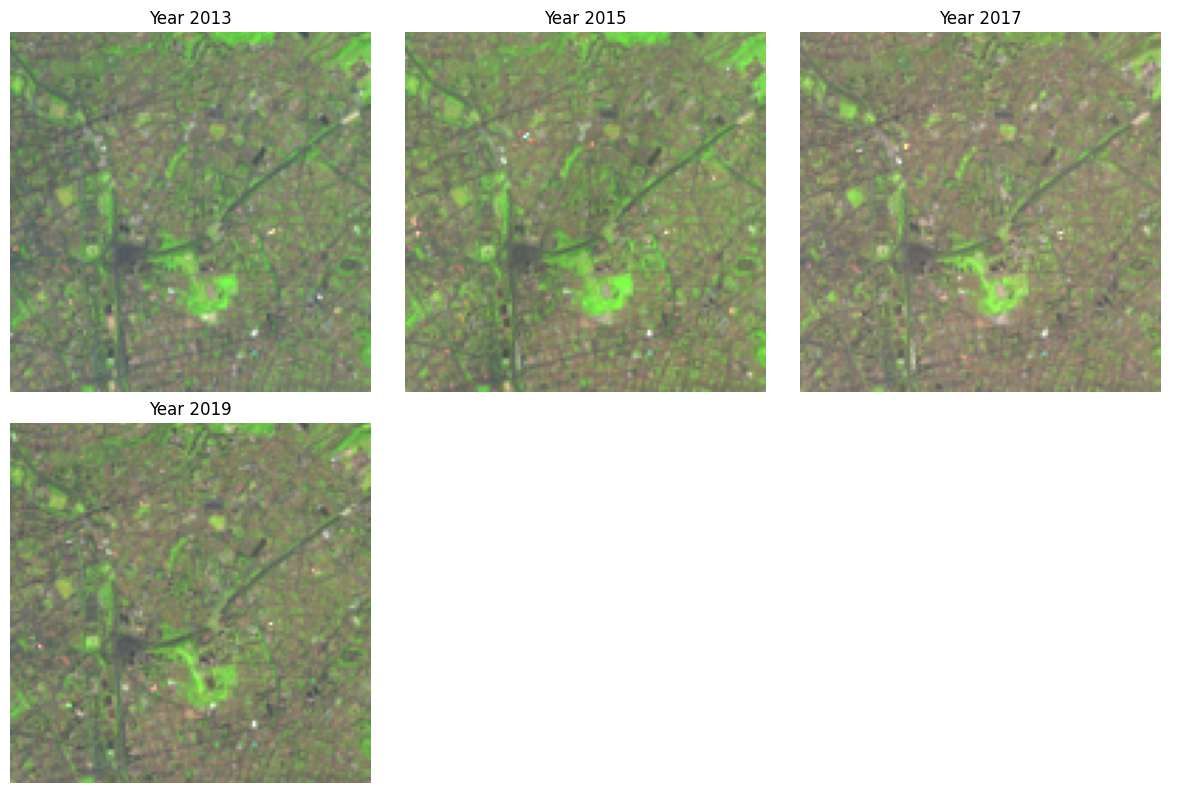

In [49]:
sample = dataset[100]
sample.plot_across_years([2013, 2015, 2017, 2019])

                                              Savings

In [37]:
base_dir = r"C:\Users\adamh\Desktop\Satelite_images\Toulouse_data.pkl"

data = load(base_dir)
show(data)

✅ Data loaded successfully!
🔎 Exploring data structure
------------------------------------------------------------
2013
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(500, 128, 128), dtype=object
  ├─ iris_patch_proportions    → dict[500]
  ├─ socioeconomic_vector      → array shape=(500, 96), dtype=float64
------------------------------------------------------------
2014
  ├─ imgs_array                → array shape=(500, 128, 128, 3), dtype=uint8
  ├─ space_coordinates         → array shape=(500, 128, 128, 2), dtype=float32
  ├─ iris_index                → array shape=(500, 128, 128), dtype=object
  ├─ iris_patch_proportions    → dict[500]
  ├─ socioeconomic_vector      → array shape=(500, 96), dtype=float64
------------------------------------------------------------
2015
  ├─ imgs_array                → array shape=(500, 128, 128

In [35]:
patch_list = [TemporalPatch(pid, data_patch) for pid in data_patch]
print(len(patch_list))

500


In [36]:
import pickle

with open("Paris.pkl", "wb") as f:
    pickle.dump(patch_list, f)
